Epoch [1/10], Step [10/17], Loss: 0.6951
Epoch [2/10], Step [10/17], Loss: 0.6902
Epoch [3/10], Step [10/17], Loss: 0.7619
Epoch [4/10], Step [10/17], Loss: 0.7161
Epoch [5/10], Step [10/17], Loss: 0.6769
Epoch [6/10], Step [10/17], Loss: 0.7092
Epoch [7/10], Step [10/17], Loss: 0.7131
Epoch [8/10], Step [10/17], Loss: 0.6910
Epoch [9/10], Step [10/17], Loss: 0.7043
Epoch [10/10], Step [10/17], Loss: 0.6945


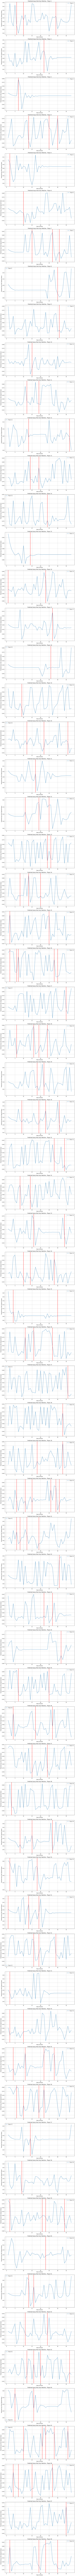

In [11]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

data = np.load('positional_all_players_tensor.npy')

X = data[:,:,:-2]
y = data[:,:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

y_train_aggregated = y_train[:, -1].unsqueeze(1)


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  
        return torch.sigmoid(out)  


input_size = X.shape[2]  
hidden_size = 128
num_layers = 2
output_size = 1

model = RNN(input_size, hidden_size, num_layers, output_size)

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.000001)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        
        outputs = model(inputs)
        labels = labels[:, -1] 
        loss = criterion(outputs.squeeze(), labels)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


with torch.no_grad():
    all_player_predictions = []
    for i in range(len(X_test)):
        player_predictions = []
        for j in range(X_test.size(1)):
            input_matches = X_test[i:i + 1, :j + 1, :]
            output = model(input_matches)
            predicted = output[0, -1].item()  
            player_predictions.append(predicted)
        all_player_predictions.append(player_predictions)



num_players = len(all_player_predictions)
num_matches = len(all_player_predictions[0])

plt.figure(figsize=(12, 6*num_players))

for i in range(num_players):
    plt.subplot(num_players, 1, i+1)
    plt.plot(range(1, num_matches + 1), all_player_predictions[i], label=f'Player {i+1}')
    

    for j in range(len(y_test[i])):
        if y_test[i][j] == 1:
            plt.axvline(x=j+1, color='r', linestyle='-', linewidth=2)

    plt.title(f'Predicted Injury Risk Over Matches - Player {i+1}')
    plt.xlabel('Match Number')
    plt.ylabel('Predicted Injury Risk (Sigmoid Value)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
